In [26]:
import numpy as np
from PIL import Image
import matplotlib as plt

In [27]:
def load_and_scale_images(image_path, watermark_path):
    image = Image.open(image_path).convert('L')  
    image = image.resize((512, 512))
    
    image_array = np.array(image)
    
    watermark = Image.open(watermark_path).convert('L')
    watermark = watermark.resize((32, 32))
    watermark_array = np.array(watermark) > 128  
    
    return image_array, watermark_array, image, watermark

In [28]:
image_array,watermark_array,input_image, watermark_image=load_and_scale_images('lena.png','watermark_image.webp')

In [29]:
#input_image = Image.open('lena.png').convert('L').resize((512, 512))  
#watermark_image = Image.open('wm.jpeg').convert('L').resize((32,32))

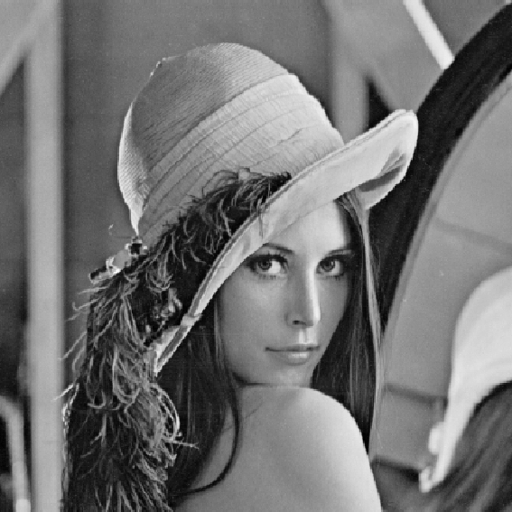

In [30]:
input_image

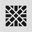

In [31]:
watermark_image

In [32]:
def shuffle_wathermark_image(wathermark_image):
    np.random.seed(42)

    wm_img_array = np.array(wathermark_image)
    shape = wm_img_array.shape
    
    wm_img_array = wm_img_array.flatten()

    np.random.shuffle(wm_img_array)

    shuffled_image_array = wm_img_array.reshape(shape)
    shuffled_image = Image.fromarray(shuffled_image_array)

    return shuffled_image

In [33]:
def split_image_into_four(image):

    width, height = image.size

    mid_width = width // 2
    mid_height = height // 2

    ftl = image.crop((0, 0, mid_width, mid_height))  
    ftr = image.crop((mid_width, 0, width, mid_height))  
    fbl = image.crop((0, mid_height, mid_width, height)) 
    fbr = image.crop((mid_width, mid_height, width, height))

    return ftl, ftr, fbl, fbr

In [34]:
def merge_image_from_four(ftl, ftr, fbl, fbr):
    width, height = ftl.size
    
    merged_image = Image.new('L', (width * 2, height * 2))

    merged_image.paste(ftl, (0, 0))  
    merged_image.paste(ftr, (width, 0)) 
    merged_image.paste(fbl, (0, height))  
    merged_image.paste(fbr, (width, height))

    return merged_image

In [35]:
import bisect

def find_interval(sorted_array, x):
    if x < sorted_array[0] or x > sorted_array[-1]:
        return "Element je van opsega"

    index = bisect.bisect_left(sorted_array, x)

    if index == 0:
        return 0
    elif index == len(sorted_array):
        return len(sorted_array)
    else:
        return index-1

In [36]:
def reconstruct_image(blocks, original_indices, block_size):
    reconstruct_image = np.zeros((512 // 2, 512 // 2))
    for (U, D, Vt), (i,j) in zip(blocks, original_indices):
        D_matrix = np.diag(D)
        r_b = np.dot(U, np.dot(D_matrix, Vt))
        reconstruct_image[i:i+block_size,j: j+block_size] = r_b

    return reconstruct_image

In [37]:
def watermark_embedding_in_d_matrix(ftl, wm, block_size=8):
    original_indices = []
    wm_array = np.array(wm)
    wm_array = wm_array.flatten()
    ftl_arr = np.array(ftl)
    d_large = []
    blocks = []
    for i in range(0, ftl_arr.shape[0], block_size):
        for j in range(0, ftl_arr.shape[1], block_size):
            block = ftl_arr[i:i+block_size, j:j+block_size]
            U, D, V = np.linalg.svd(block)
            d_large.append(D[0])
            original_indices.append((i,j))
            blocks.append((U, D, V))

    #d_large.sort()
    T = 60
    d_max = max(d_large)
    d_min = min(d_large)
    d_low = np.linspace(d_min - T, d_max)
    d_high = np.linspace(d_min, d_max + T)


    bit_idx = 0
    for d in d_large:
        i = find_interval(d_low, d)
        dlow = d_low[i]
        dhigh = d_high[i]
        print(f'Donja granica {dlow}')
        print(f'Gornja granica {dhigh}')
        print(f'Singularna vrednosti{d}')
        print('-------------------')
        if wm_array[bit_idx] == 1:
            new_d = (dlow + (dhigh + dlow)/2)/2
        else:
            new_d = (dhigh + (dhigh + dlow)/2)/2
        blocks[bit_idx][1][0] = new_d
        bit_idx += 1

    result = reconstruct_image(blocks, original_indices, 8)
    return result

In [38]:
def watermark_embedding_in_u_matrix(fbr, wm, block_size=8, alpha=0.01):
    original_indices = []
    wm_array = np.array(wm)
    wm_array = wm_array.flatten()
    fbr_arr = np.array(fbr)
    blocks = []

    for i in range(0, fbr_arr.shape[0], block_size):
        for j in range(0, fbr_arr.shape[1], block_size):
            block = fbr_arr[i:i+block_size, j:j+block_size]
            U, D, Vt = np.linalg.svd(block)
            original_indices.append((i, j))
            blocks.append((U, D, Vt))

    bit_idx = 0
    for U, D, Vt in blocks:
        if bit_idx >= len(wm_array):
            break
        
        u11 = U[0, 0]
        u21 = U[1, 0]
        diff_u = u11 - u21

        if wm_array[bit_idx] == 1:
            if diff_u <= alpha:
                U[0, 0] += (alpha - diff_u) / 2
                U[1, 0] -= (alpha - diff_u) / 2
        else:
            if diff_u >= -alpha:
                U[0, 0] -= (diff_u + alpha) / 2
                U[1, 0] += (diff_u + alpha) / 2
        
        bit_idx += 1

    result = reconstruct_image(blocks, original_indices, block_size)
    return result


In [43]:
def watermak_embedding(image, wm):
    ftl, ftr, fbl, fbr = split_image_into_four(input_image)
    
    ftl_new = watermark_embedding_in_d_matrix(ftl, wm)
    ftl_new = Image.fromarray(ftl_new).convert('L')
    ftl_new.show()
    
    fbr_new = watermark_embedding_in_u_matrix(fbr, wm)
    fbr_new = Image.fromarray(fbr_new).convert('L')
    fbr_new.show()
    
    merged_image = merge_image_from_four(ftl_new, ftr, fbl, fbr_new)
    merged_image.show()
    merged_image.save('watermarked_image.png')
    
    return merged_image

In [40]:
shuffled_image = shuffle_wathermark_image(watermark_image)
shuffled_image.size

(32, 32)

In [41]:
shuffled_image.save('shuffled_wm_image.png')

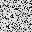

In [42]:
shuffled_image

In [20]:
ftl, ftr, fbl, fbr = split_image_into_four(input_image)

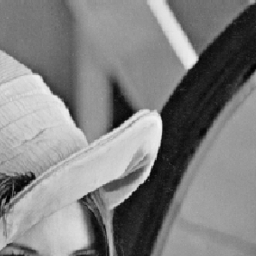

In [21]:
ftr

In [22]:
img = merge_image_from_four(ftl, ftr, fbl, fbr)

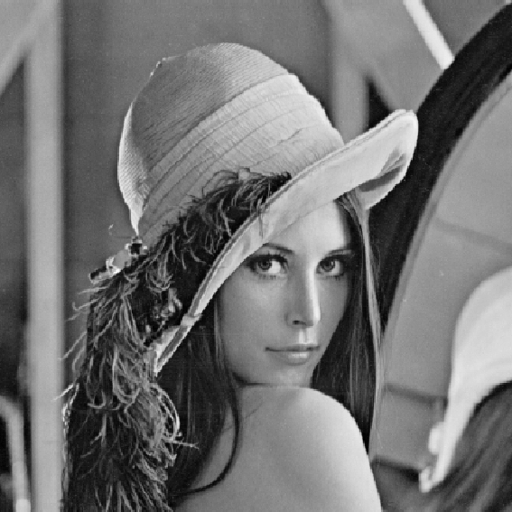

In [23]:
img

Donja granica 1220.1405421237073
Gornja granica 1280.1405421237073
Singularna vrednosti1247.176713135579
-------------------
Donja granica 1220.1405421237073
Gornja granica 1280.1405421237073
Singularna vrednosti1222.5745041384198
-------------------
Donja granica 1189.15180149349
Gornja granica 1249.15180149349
Singularna vrednosti1202.9747339094824
-------------------
Donja granica 1189.15180149349
Gornja granica 1249.15180149349
Singularna vrednosti1192.6924352767394
-------------------
Donja granica 1251.1292827539246
Gornja granica 1311.1292827539246
Singularna vrednosti1251.3532119233605
-------------------
Donja granica 1344.0955046445765
Gornja granica 1404.0955046445765
Singularna vrednosti1349.1694167138544
-------------------
Donja granica 1282.118023384142
Gornja granica 1342.118023384142
Singularna vrednosti1299.4905797444794
-------------------
Donja granica 941.2418764517519
Gornja granica 1001.2418764517519
Singularna vrednosti941.9015590238773
-------------------
Donja

Donja granica 817.2869139308827
Gornja granica 877.2869139308827
Singularna vrednosti846.5992857484575
-------------------
Donja granica 693.3319514100136
Gornja granica 753.3319514100136
Singularna vrednosti709.5420256955371
-------------------
Donja granica 755.3094326704481
Gornja granica 815.3094326704481
Singularna vrednosti769.7737537220339
-------------------
Donja granica 817.2869139308827
Gornja granica 877.2869139308827
Singularna vrednosti844.193896841658
-------------------
Donja granica 848.2756545611
Gornja granica 908.2756545611
Singularna vrednosti874.3852108906909
-------------------
Donja granica 910.2531358215346
Gornja granica 970.2531358215346
Singularna vrednosti928.1221944236203
-------------------
Donja granica 941.2418764517519
Gornja granica 1001.2418764517519
Singularna vrednosti943.0883820086434
-------------------
Donja granica 879.2643951913172
Gornja granica 939.2643951913172
Singularna vrednosti907.9556504866239
-------------------
Donja granica 1189.151

-------------------
Donja granica 166.52336069631997
Gornja granica 226.52336069631997
Singularna vrednosti195.5346200661027
-------------------
Donja granica 383.4445451078409
Gornja granica 443.4445451078409
Singularna vrednosti399.3839104605977
-------------------
Donja granica 383.4445451078409
Gornja granica 443.4445451078409
Singularna vrednosti400.45631855978473
-------------------
Donja granica 352.4558044776236
Gornja granica 412.4558044776236
Singularna vrednosti375.3121440571816
-------------------
Donja granica 662.3432107797963
Gornja granica 722.3432107797963
Singularna vrednosti664.0660243132514
-------------------
Donja granica 197.51210132653725
Gornja granica 257.5121013265372
Singularna vrednosti208.89347436591996
-------------------
Donja granica 538.3882482589273
Gornja granica 598.3882482589273
Singularna vrednosti568.2901942028407
-------------------
Donja granica 910.2531358215346
Gornja granica 970.2531358215346
Singularna vrednosti933.8862219940135
-----------

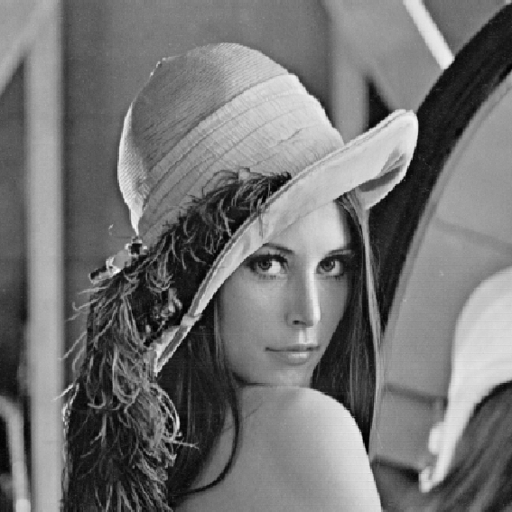

In [44]:
watermak_embedding(input_image,shuffled_image)